In [48]:
!conda install -y numpy
!conda install -y matplotlib
!pip3 install torchvision
!pip3 install natsort

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [60]:
import torchvision
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

train_data_path = "./3classes/train/"
eval_data_path = "./3classes/validation/"

In [61]:
import numpy as np

transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.ColorJitter(),
    #transforms.RandomCrop(224),
    transforms.CenterCrop(200),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(200),
    transforms.ToTensor()
])

In [62]:
from torch.utils.data import Dataset
import os
import natsort
from PIL import Image

class TestDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image
    

In [63]:
train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=transforms)
eval_data = torchvision.datasets.ImageFolder(root=eval_data_path, transform=transforms)
#test_data = TestDataSet(valid_data_path, transform=transforms)


In [86]:
EPOCH = 20               # train the training data n times, to save time, we just train 1 epoch
LR = 0.001 
batch_size = 16
train_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
eval_loader=torch.utils.data.DataLoader(eval_data,batch_size=batch_size, shuffle=False)

In [87]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)


cpu


In [88]:
#!pip3 install tensorboard

In [89]:
#!pip3 install visdom

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (out): Sequential(
    (0): Linear(in_features=40000, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.

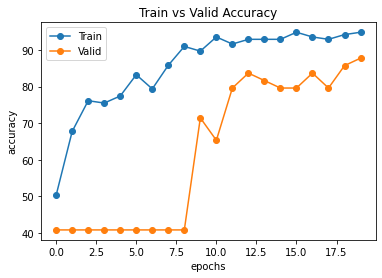

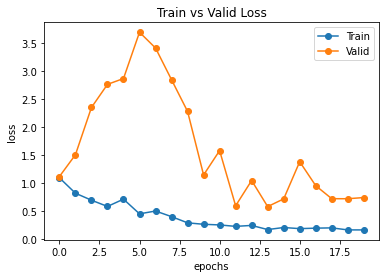

In [92]:
import torch.nn as nn
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (3, 64, 64)
            nn.Conv2d(
                in_channels=3,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after Conv2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 64, 64)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 32, 32)
            nn.BatchNorm2d(16),
        )
        self.conv2 = nn.Sequential(         # input shape (16, 32, 32)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 32, 32)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 16, 16)
            nn.BatchNorm2d(32)
        )
        self.conv3 = nn.Sequential(         # input shape (32, 16, 16)
            nn.Conv2d(32, 64, 5, 1, 2),     # output shape (64, 16, 16)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (64, 8, 8)
            nn.BatchNorm2d(64)
        )
        self.out = nn.Sequential(
            nn.Linear(40000, 2048),   # fully connected layer, output 10 classes
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 3)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output#, x    # return x for visualization


cnn = CNN()
print(cnn)  # net architecture

optimizer = torch.optim.SGD(cnn.parameters(),lr=LR,momentum=0.9)#torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


def fit(model, train_loader, optimizer, loss_func):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    total = 0
    
    for step, (b_x, b_y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        optimizer.zero_grad()           # clear gradients for this training step
        output = model(b_x)               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        #train_running_loss += loss.item()
        _, predicted = output.max(1)
        total += b_y.size(0)
        train_running_correct += predicted.eq(b_y).sum().item()
        
        # backward + optimize only if in training phase
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        
        train_running_loss += loss.item()
        #viz.line([loss.item()], [global_step], win='loss', update='append') #loss可视化
     
        
    train_loss = train_running_loss / len(train_loader)
    train_accuracy = 100. * train_running_correct / total
    return train_loss, train_accuracy

def evalidate(model, test_loader, optimizer, loss_func):
    print('Testing')
    model.eval()
    eval_running_loss = 0.0
    eval_running_correct = 0
    total = 0
    
    #不需要计算梯度，所以加上不求导，验证集一定要加上这几句话
    with torch.no_grad():
        for step, (b_x, b_y) in enumerate(test_loader):   # gives batch data, normalize x when iterate train_loader
            output = model(b_x)               # cnn output
            loss = loss_func(output, b_y)   # cross entropy loss
            eval_running_loss += loss.item()
            
            _, predicted = output.max(1)
            total += b_y.size(0)
            eval_running_correct += predicted.eq(b_y).sum().item()

        eval_loss = eval_running_loss / len(eval_loader)
        eval_accuracy = 100. * eval_running_correct / total
        return eval_loss, eval_accuracy
    
    

train_loss, train_accuracy = [], []
eval_loss, eval_accuracy = [], []

# training and testing
for epoch in range(EPOCH):
    #print(f"Epoch {epoch+1} of {EPOCH}")
    train_epoch_loss, train_epoch_accuracy = fit(
        cnn, train_loader, optimizer, loss_func
    )
    
    scheduler.step()
    print(optimizer.param_groups[0]['lr'])
    
    eval_epoch_loss, eval_epoch_accuracy = evalidate(
        cnn, eval_loader, optimizer, loss_func
    )

    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    
    eval_loss.append(eval_epoch_loss)
    eval_accuracy.append(eval_epoch_accuracy)
    
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_epoch_loss,train_epoch_accuracy))
    print('Eval Loss: %.3f | Accuracy: %.3f'%(eval_epoch_loss,eval_epoch_accuracy))

plt.plot(train_accuracy,'-o')
plt.plot(eval_accuracy,'-o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Valid'])
plt.title('Train vs Valid Accuracy')
plt.show()

plt.plot(train_loss,'-o')
plt.plot(eval_loss,'-o')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Valid'])
plt.title('Train vs Valid Loss')
plt.show()

In [58]:
#cnn.eval()

from PIL import Image

img = Image.open('./test/cat/1.jpg')
img = transforms(img)
img = img.unsqueeze(0)

prediction = cnn(img)
prediction = prediction.argmax()
print(prediction)

FileNotFoundError: [Errno 2] No such file or directory: './test/cat/1.jpg'